100%|██████████| 170M/170M [00:01<00:00, 90.1MB/s]


Epoch 1/10, Loss: 1.4406
Epoch 2/10, Loss: 1.0944
Epoch 3/10, Loss: 0.9432
Epoch 4/10, Loss: 0.8501
Epoch 5/10, Loss: 0.7682
Epoch 6/10, Loss: 0.6968
Epoch 7/10, Loss: 0.6318
Epoch 8/10, Loss: 0.5764
Epoch 9/10, Loss: 0.5189
Epoch 10/10, Loss: 0.4627
Accuracy on test data: 70.30%


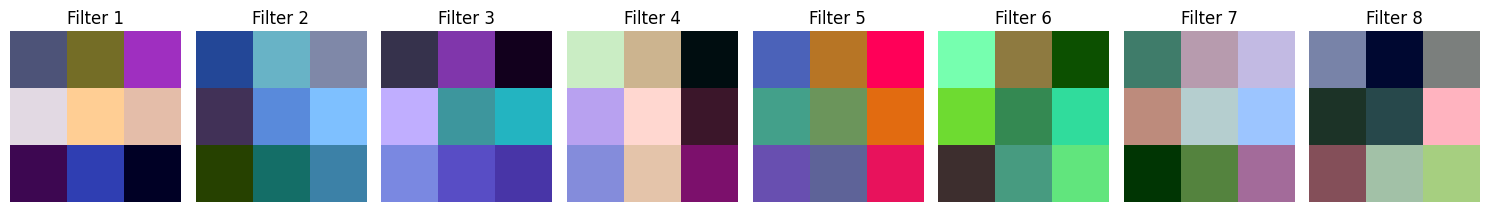

In [1]:
#exp:04
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Step 1: Load and preprocess CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # normalize to [-1, 1]
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

classes = trainset.classes

# Step 2: Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  # 3x32x32 -> 16x32x32
        self.pool = nn.MaxPool2d(2, 2)               # halves spatial size
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1) # 16x16x16 -> 32x16x16 (before pooling)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)        # fully connected layer
        self.fc2 = nn.Linear(128, 10)                 # output classes
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # conv1 + relu + pool -> 16x16x16
        x = self.pool(self.relu(self.conv2(x)))  # conv2 + relu + pool -> 32x8x8
        x = x.view(-1, 32 * 8 * 8)                # flatten
        x = self.relu(self.fc1(x))                 # fully connected + relu
        x = self.fc2(x)                            # output logits
        return x

# Step 3: Set up device, model, loss function, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 4: Train the CNN
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(trainloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

# Step 5: Evaluate model performance on test data
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on test data: {accuracy:.2f}%")

# Step 6: Visualize filters from the first convolutional layer
def visualize_filters(layer, n_filters=8):
    filters = layer.weight.data.clone().cpu()
    fig, axs = plt.subplots(1, n_filters, figsize=(15, 4))
    for i in range(n_filters):
        f = filters[i]
        # Normalize filter values to [0,1] for display
        f = (f - f.min()) / (f.max() - f.min())
        axs[i].imshow(f.permute(1, 2, 0))  # (C, H, W) to (H, W, C)
        axs[i].axis('off')
        axs[i].set_title(f'Filter {i+1}')
    plt.tight_layout()
    plt.show()

visualize_filters(model.conv1, n_filters=8)
